In [790]:
from __future__ import division, print_function

import GPy
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [791]:
# parameter grid
def combinations(arrays):
    """Return a single array with combinations of parameters
    
    Parameters
    ----------
    arrays - list of np.array
    
    Returns
    -------
    array - np.array
        An array that contains all combinations of the input arrays
    """
    return np.array(np.meshgrid(*arrays)).T.reshape(-1, len(arrays))

In [792]:
def line_search_bisection(f, bound, accuracy):
    """Maximize c so that constraint fulfilled.
    
    Parameters
    ----------
    f - callable
        A function that takes a scalar value and return True if
        the constraint is fulfilled, False otherwise.
    bound - list
        Interval within which to search
    accuracy - float
        The interval up to which the algorithm shall search
        
    Returns
    -------
    c - float
        The maximum value c so that the constraint is fulfilled    
    """
    # Break if lower bound does not fulfill constraint
    if not f(bound[0]):
        return None
    
    if f(bound[1]):
        return bound[1]
    
    while bound[1] - bound[0] > accuracy:
        mean = (bound[0] + bound[1]) / 2
        
        if f(mean):
            bound[0] = mean
        else:
            bound[1] = mean
    
    return bound[0]

In [793]:
def lqr(A, B, Q, R):
    """
    Compute the continuous time LQR-controller. 
    
    Parameters
    ----------
    A - np.array
    B - np.array
    Q - np.array
    R - np.array
     
    Returns
    -------
    K - np.array
        Controller matrix
    P - np.array
        Cost to go matrix
    """
 
    #first, try to solve the ricatti equation
    P = sp.linalg.solve_continuous_are(A, B, Q, R)
     
    #compute the LQR gain
    K = np.linalg.solve(R, B.T.dot(P))
     
    return K, P


def quadratic_lyapunov_function(x, P):
    """
    Compute V(x) for quadratic Lyapunov function
    
    V(x) = x.T P x
    
    Equivalent, but slower implementation:
    np.array([ xi.dot(p.dot(xi.T)) for xi in x])
    
    Parameters
    ----------
    x - np.array
        2d array that has a vector x on each row
    P - np.array
        2d cost matrix for lyapunov function

    Returns
    -------
    V - np.array
        1d array with V(x)
    dV - np.array
        2d array with dV(x)/dx on each row
    """
    return np.sum(x.dot(P) * x, axis=1), x.dot(P)

In [794]:
def compute_V_dot(dV, gp_mean, gp_var, beta=2.):
    """
    Compute the safe set
    
    Parameters
    ----------
    dV - np.array
        The derivatives of the Lyapunov function at grid points
    gp_mean - np.array
        gp mean of the dynamics (including prior dynamics as mean)
    gp_var - np.array
        gp var of the dynamics
    beta - float
        The confidence interval for the GP-prediction
    """    
    # V_dot_mean = dV * mu
    # V_dot_var = sum_i(|dV_i| * var_i)
    # If output dimensions were correlated, the variance could be further reduced
    # by considering correlations (predicting the sum term directly).
    return np.sum(dV * gp_mean, axis=1) + beta * np.sqrt(np.sum(dV**2 * gp_var, axis=1)) 

def get_safe_set(V_dot, threshold, S0=None):
    """
    Compute the safe set
    
    Parameters
    ----------
    V_dot - np.array
        V_dot at all grid points
    threshold - float
        The safety threshold, in the paper threshold = tau * L
    S0 - np.array
        The deterministic safe set
    """    
    if S0 is None:
        return V_dot < -threshold
    else:
        return np.logical_or(S0, V_dot < -threshold)
        
def find_max_levelset(S, V, accuracy, interval=None):
    """
    Find maximum level set of V in S.
    
    Parameters
    ----------
    S - boolean array
        Elements are True if V_dot <= L tau
    V - np.array
        1d array with values of Lyapunov function.
    accuracy - float
        The accuracy up to which the level set is computed
    interval - list
        Interval within which the level set is search. Defaults
        to [0, max(V) + accuracy]
        
    Returns
    -------
    c - float
        The value of the maximum level set
    """
    
    def levelset_is_safe(c):
        """
        Return true if V(c) is subset of S
        
        Parameters
        ----------
        c: float
            The level set value
            
        Returns:
        safe: boolean
        """
        # All points that have V<=c should be safe (have S=True)
        return np.all(S[V <= c])
    
    if interval is None:
        interval = [0, np.max(V) + accuracy]
    return line_search_bisection(levelset_is_safe,
                                 interval,
                                 accuracy)
        

In [795]:
tau = 0.005

# x_min, x_max, accuracy
grid_param = [(-math.radians(45), math.radians(45), tau),
              (-2, 2, tau)]

extent = np.array([grid_param[0][0], grid_param[0][1], grid_param[1][0], grid_param[1][1]])

grid = [np.arange(*x) for x in grid_param]
num_samples = [len(x) for x in grid]
grid = combinations(grid)

print('Grid size: {0}'.format(len(grid)))

Grid size: 252000


In [796]:
n = 2
m = 1

mass = 0.1
friction = 0.
length = 0.5
gravity = 9.81

x_max = np.deg2rad(45)
u_max = gravity * mass * length * np.sin(x_max)
# u_max = np.deg2rad(45)
# x_max = np.rad2deg(np.arcsin(u_max / (mass * gravity * length)))

inertia = mass * length ** 2

A = np.array([[0, 1],
              [math.sqrt(gravity / length), -friction / inertia]])

B = np.array([[0],
              [1 / intertia]])

Q = np.array([[1, 0], [0, 1]], dtype=np.float)
R = np.array([[1]], dtype=np.float)

# x_n = inv(Tx) * x
Tx = np.diag([x_max, gravity / length * math.cos(x_max) * 0.1])
Tu = np.array([[u_max]])

Tx_inv = np.diag(np.diag(Tx)**(-1))
Tu_inv = np.diag(np.diag(Tu)**(-1))

Q = Tx_inv.T.dot(Q.dot(Tx_inv))
R = Tu_inv.T.dot(R.dot(Tu_inv))

Q *= np.array(1e-3, dtype=np.float)
R *= np.array(1e-3, dtype=np.float)


def ode(x, u):
    return np.hstack([x[:, [1]],
                      gravity / length * np.sin(x[:, [0]]) + u / inertia - friction / inertia * x[:, [1]]])

K, P = lqr(A, B, Q, R)

def control_law(x):
    return -x.dot(K.T)

def true_dynamics(x):
    x = np.asarray(x)
    u = control_law(x)
    u = np.clip(u, -0.2, 0.2)
    return ode(x, u)

def prior_dynamics(x):
    x = np.asarray(x)
    u = control_law(x)
    return x.dot(A.T) + u.dot(B.T)

# Initial safe set
S0 = np.logical_and(np.abs(grid[:, 0]) < np.deg2rad(5), True)

if not np.any(S0):
    print('No initial safe points!')

In [797]:
np.max(np.abs(prior_dynamics(grid) - true_dynamics(grid)))

44.282921353190957

#### Kernel definition

The inverted pendulum model is of the form
\begin{equation}
\ddot{\theta} = \frac{mgl \sin(\theta) + \tau}{m l^2}
\end{equation}

or, with the state vector $\mathbf{x} = [\mathbf{x}_1, \mathbf{x}_2] = [\theta, \dot{\theta}]$, the dynamics are
\begin{equation}
\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2}
\end{matrix} \right]
\end{equation}

The first part of this equation says that the angle is equal to the integrated angular velocity. This is a intuitively true, irrespective of model errors. As such, we only train a model on the second part of the dynamics. That is
\begin{equation}
\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2} + g_\pi(\mathbf{x})
\end{matrix} \right]
\end{equation}


In [798]:
mf = GPy.core.Mapping(2, 1)
mf.f = lambda x: prior_dynamics(x)[:, [1]]
mf.update_gradients = lambda a,b: None

kernel = GPy.kern.RBF(input_dim=2, lengthscale=0.5, variance=20**2, ARD=True)
likelihood = GPy.likelihoods.Gaussian(variance=0.01**2)
gp = GPy.core.GP(np.array([[0, 0]]), np.array([[0]]), kernel, likelihood, mean_function=mf)

def predict_model(gp, x):
    gp_mean, gp_var = gp._raw_predict(x)
    gp_mean = np.hstack([x[:, [1]], gp_mean])
    gp_var = np.hstack([np.zeros_like(gp_var), gp_var])
    return gp_mean, gp_var
L = 3

In [847]:
# Lipschitz constants of Lyapunov function
L_dV = np.max(P)
L_V = np.max(dV)


kernel_lengthscale = np.min(gp.kern.lengthscale).squeeze().tolist()
kernel_var = gp.kern.variance.values.squeeze().tolist()

# Dynamics Lipschitz constants
L_g = np.sqrt(kernel_var) / kernel_lengthscale
L_f = max(np.max(A), np.max(B))

# Function bounds
B_g = np.sqrt(kernel_var)
B_f = np.max(prior_dynamics(grid))

B_true = np.max(true_dynamics(grid))

L = (B_g + B_f) * L_V + L_dV * (L_g + L_f)
L_true = B_true * L_V + L_dV * L_f

In [848]:
print(L, L_true)

0.157206684556 0.0690933842269


## True safe levelset

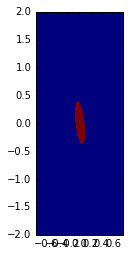

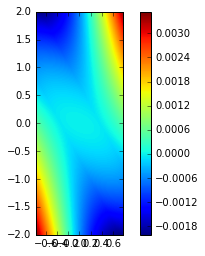

Number of safe points: 3852/252000


In [853]:
V, dV = quadratic_lyapunov_function(grid, P)
V_max = np.max(V)
accuracy = V_max / 1e10

V_dot_true = np.sum(dV * true_dynamics(grid), axis=1)
S = V_dot_true <= -L*tau
if np.all(S):
    print('All points safe')
elif not np.any(S):
    print('All points unsafe')

c = find_max_levelset(np.logical_or(S, S0), V, accuracy)
S[:] = V <= c
plt.imshow(np.reshape(S, num_samples).T, extent=extent, origin='lower')
plt.show()

c = plt.imshow(np.reshape(V_dot_true, num_samples).T, extent=extent, origin='lower')
plt.colorbar(c)
plt.show()

print('Number of safe points: {0}/{1}'.format(np.count_nonzero(S), grid.shape[0]))

## Online learning

In [823]:
V, dV = quadratic_lyapunov_function(grid, P)
    
def update_gp():
    dynamics_mean, dynamics_var = predict_model(gp, grid)
    if np.any(gp_var < 0):
        print('negative variance Oo')
    V_dot = compute_V_dot(dV, dynamics_mean, dynamics_var, beta=2.)
    S = get_safe_set(V_dot, L*tau, S0=S0)
    c = find_max_levelset(S, V, accuracy)
    S[:] = V <= c
    max_id = np.argmax(dynamics_var[S, 1])
    max_state = grid[S][[max_id], :].copy()
    gp.set_XY(np.vstack([gp.X, max_state]),
              np.vstack([gp.Y, true_dynamics(max_state)[:, [1]]]))
    return S

In [824]:
for i in range(10):
    update_gp()
S = update_gp()
print(np.count_nonzero(S))

3852


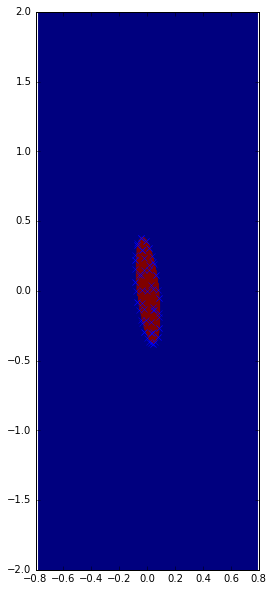

In [825]:
fig = plt.figure(figsize=(10, 10))
c = plt.imshow(np.reshape(S, num_samples).T, extent=extent, origin='lower')
# c = plt.imshow(np.reshape(V_dot, num_samples).T < 0, extent=extent, origin='lower', cmap='viridis')
# plt.colorbar(c)
plt.plot(gp.X[:, 0], gp.X[:, 1], 'x')

In [ ]:
error = np.abs(true_dynamics(grid)[:, 1] - prior_dynamics(grid)[:, 1])
c = plt.imshow(np.reshape(error, num_samples).T < 0, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(c)

In [ ]:
np.min(error)